In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix, classification_report
from torchmetrics import HammingDistance, Accuracy, F1Score, Precision, Recall
import seaborn as sns
import re
import copy

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

## Import Data

In [ ]:
job_level_data = pd.read_csv("data/JobLevelData_preproc.csv")
job_level_data

In [ ]:
classes_labels = ['Chief Officer' 'Director' 'Individual Contributor/Staff' 'Manager'
 'Vice President']

## Dataset Loading

In [22]:
RANDOM_SEED = 42
MAX_LEN = 30
BATCH_SIZE = 64
MAX_EPOCHS = 50
EARLY_STOPPING_PAT = 4
THRESHOLD = 0.5

In [ ]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-6_H-256_A-4')

In [23]:
# handle input data preprocessing
class JobTitlesDataset(Dataset):
    def __init__(self, titles, labels, tokenizer, max_len):
        self.titles = titles
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len  # maximum length of tokenized sentence

    def __len__(self):
        return len(self.titles)

    def __getitem__(self, item):
        encoded_data = self.tokenizer.encode_plus(
            self.titles[item],
            add_special_tokens=True,  # tokens required for BERT
            max_length=self.max_len,
            return_token_type_ids=False,  # no sentence pair task
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # differentiate between padding and data
            return_tensors='pt'
        )
        return {
            'input_ids': encoded_data['input_ids'].flatten(),
            'attention_mask': encoded_data['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.float)
        }

### Train Test Split

In [24]:
# TODO: implement stratification
X_train, X_test, y_train, y_test = train_test_split(
    job_level_data['Title'],
    job_level_data['Label'],
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"Train data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Train data: (1780,)
Test data: (446,)


In [25]:
train_dataset = JobTitlesDataset(
    titles=X_train,
    labels=y_train,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = JobTitlesDataset(
    titles=X_test,
    labels=y_test,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Model Definition and Training

BERT models are a powerful tools for various text classification problems. For this task, the mini BERT model was chosen due to its strong performance in understanding textual data and its lower complexity compared to the base BERT model. Although the model is computationally expensive, it is capable of capturing nuances in the data, such as misspellings, non-expanded abbreviations, variations in job titles.

However, it is acknowledged that BERT might not be the optimal solution due to its complexity and model size, which is approximately 50MB, especially given the nature of the data (short and simple sentences). An ideal approach would be to establish a baseline model with a simpler architecture and then compare it with the BERT model, for example, using TF-IDF vectorization combined with a Logistic Regression classifier.

Another strategy worth exploring is a hybrid approach, where BERT is used solely for generating embeddings that are then fed into a simpler classifier.

Due to time constraints, alternative models were not implemented, but are recommended for further exploration.

In [26]:
class JobTitleClassifier(nn.Module):
    def __init__(self, n_classes):
        super(JobTitleClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('google/bert_uncased_L-6_H-256_A-4')  # Pre-trained BERT-Mini model
        self.dropout = torch.nn.Dropout(0.4) # regularization
        self.linear = torch.nn.Linear(self.bert.config.hidden_size, n_classes) # classification 
    
    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids, attention_mask)
        output = self.dropout(output.last_hidden_state[:, 0, :])
        output = self.linear(output)
        return output

model_bert_classifier = JobTitleClassifier(len(classes_labels)).to(device)

As highlighted in the EDA, the data is highly imbalanced. To address this, class weights will be calculated and passed to the loss function to give more weight to underrepresented classes.

In [27]:
# import labels_count from EDA notebook
labels_count = {'Chief Officer': 163,
 'Director': 497,
 'Individual Contributor/Staff': 1105,
 'Manager': 211,
 'Vice President': 403}

{'Chief Officer': 163,
 'Director': 497,
 'Individual Contributor/Staff': 1105,
 'Manager': 211,
 'Vice President': 403}

In [28]:
total_positives = sum(count for label, count in labels_count.items())
class_weights = [total_positives / count for label, count in labels_count.items()]

class_weights = np.array(class_weights)
class_weights = class_weights * (len(class_weights) / class_weights.sum())
class_weights = torch.FloatTensor(class_weights).to(device)

class_weights

tensor([1.8850, 0.6182, 0.2781, 1.4562, 0.7624], device='mps:0')

In [29]:
adam_optimizer = torch.optim.Adam(model_bert_classifier.parameters(), lr=1e-5)
bce_loss = nn.BCEWithLogitsLoss(pos_weight=class_weights) # includes sigmoid activation
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, mode='min', patience=2, factor=0.2)

In [30]:
def train_classifier(model,
                     data_loader,
                     loss_fn,
                     optimizer,
                     device):
    model = model.train()
    losses = []

    for batch_num, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        true_labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, true_labels)
        losses.append(loss.item())
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(losses)


In [31]:
def validation(model,
               data_loader,
               loss_fn,
               device):
    model = model.eval()
    losses = []
    predictions = []
    targets = []

    # ensures no gradients are computed during test mode
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            true_labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            eval_loss = loss_fn(outputs, true_labels).item()
            losses.append(eval_loss)

            preds = torch.sigmoid(outputs)  # get probabilities
            predictions.append(preds.cpu())
            targets.append(true_labels.cpu())
            
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)

    return np.mean(losses), predictions, targets

### Training and Evaluation Process
According to [Correlation analysis of performance measures for multi-label classification (2013)](https://www.sciencedirect.com/science/article/abs/pii/S0306457318300165), these are the most widely-used performance measures for multi-label classification:
- **Hamming Loss**: the most recommended due to its lack of correlation with other measures (avoiding redundancy) and being the most employed in literature at the time of paper writing.
- **F1 and Accuracy**: have strong correlation with other metrics, making them representative measures that reduce the need to report multiple similar metrics.

In [32]:
classes_num = len(classes_labels)

hamming_loss = HammingDistance(task='multilabel', num_labels=classes_num).to(device)
accuracy = Accuracy(task='multilabel', num_labels=5).to(device)
f1 = F1Score(task='multilabel', num_labels=classes_num).to(device)
precision = Precision(task='multilabel', num_labels=classes_num).to(device)
recall = Recall(task='multilabel', num_labels=classes_num).to(device)

hamming_loss_scores = []
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

In [33]:
train_losses = []
val_losses = []

best_loss = float('inf')
best_model_weights = None
best_predictions = None
best_targets = None
patience = EARLY_STOPPING_PAT

for epoch in range(MAX_EPOCHS):
    print(f'Epoch {epoch + 1}')

    # Training
    train_loss = train_classifier(model_bert_classifier, train_loader, bce_loss, adam_optimizer, device)
    train_losses.append(train_loss)

    # Validation
    val_loss, predictions, targets = validation(model_bert_classifier, test_loader, bce_loss, device)
    val_losses.append(val_loss)

    # Update learning rate
    plateau_scheduler.step(val_loss)
    
    # Thresholding
    predictions = (predictions >= THRESHOLD).long()
    predictions = predictions.to(device)
    targets = targets.to(device)
    
    # Metrics
    accuracy_score = accuracy(targets, predictions)
    f1_score = f1(targets, predictions)
    hamming_loss_score = hamming_loss(targets, predictions)
    precision_score = precision(targets, predictions)
    recall_score = recall(targets, predictions)
    
    print(f"Current learning rate: {adam_optimizer.param_groups[0]['lr']}")
    print(f"Training loss: {train_loss:.5f}, Validation loss: {val_loss:.5f}")
    print(f"Accuracy: {accuracy_score:.5f}")
    print(f"F1: {f1_score:.5f}")
    print(f"Hamming Loss: {hamming_loss_score:.5f}")
    print(f"Precision: {precision_score:.5f}, Recall: {recall_score:.5f}")
    

    hamming_loss_scores.append(hamming_loss_score.cpu())
    f1_scores.append(f1_score.cpu())
    accuracy_scores.append(accuracy_score.cpu())
    precision_scores.append(precision_score.cpu())
    recall_scores.append(recall_score.cpu())
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model_bert_classifier.state_dict())
        best_predictions = predictions
        best_targets = targets
        patience = EARLY_STOPPING_PAT 
    else:
        patience -= 1
        if patience == 0:
            break

    print()
    
model_bert_classifier.load_state_dict(best_model_weights)

Epoch 1
Current learning rate: 1e-05
Training loss: 0.45588, Validation loss: 0.36625
Accuracy: 0.78520
F1: 0.00000
Hamming Loss: 0.21480
Precision: 0.00000, Recall: 0.00000

Epoch 2
Current learning rate: 1e-05
Training loss: 0.36599, Validation loss: 0.32813
Accuracy: 0.78520
F1: 0.00000
Hamming Loss: 0.21480
Precision: 0.00000, Recall: 0.00000

Epoch 3
Current learning rate: 1e-05
Training loss: 0.32662, Validation loss: 0.28281
Accuracy: 0.81570
F1: 0.25137
Hamming Loss: 0.18430
Precision: 0.14405, Recall: 0.98571

Epoch 4
Current learning rate: 1e-05
Training loss: 0.28458, Validation loss: 0.23855
Accuracy: 0.88386
F1: 0.64666
Hamming Loss: 0.11614
Precision: 0.49478, Recall: 0.93307

Epoch 5
Current learning rate: 1e-05
Training loss: 0.24729, Validation loss: 0.20483
Accuracy: 0.91928
F1: 0.78155
Hamming Loss: 0.08072
Precision: 0.67223, Recall: 0.93333

Epoch 6
Current learning rate: 1e-05
Training loss: 0.21487, Validation loss: 0.17752
Accuracy: 0.94619
F1: 0.86696
Hamming L

<All keys matched successfully>

In [34]:
torch.save(model_bert_classifier.state_dict(), 'models/job_title_classification_model.pth')

## Results Interpretation

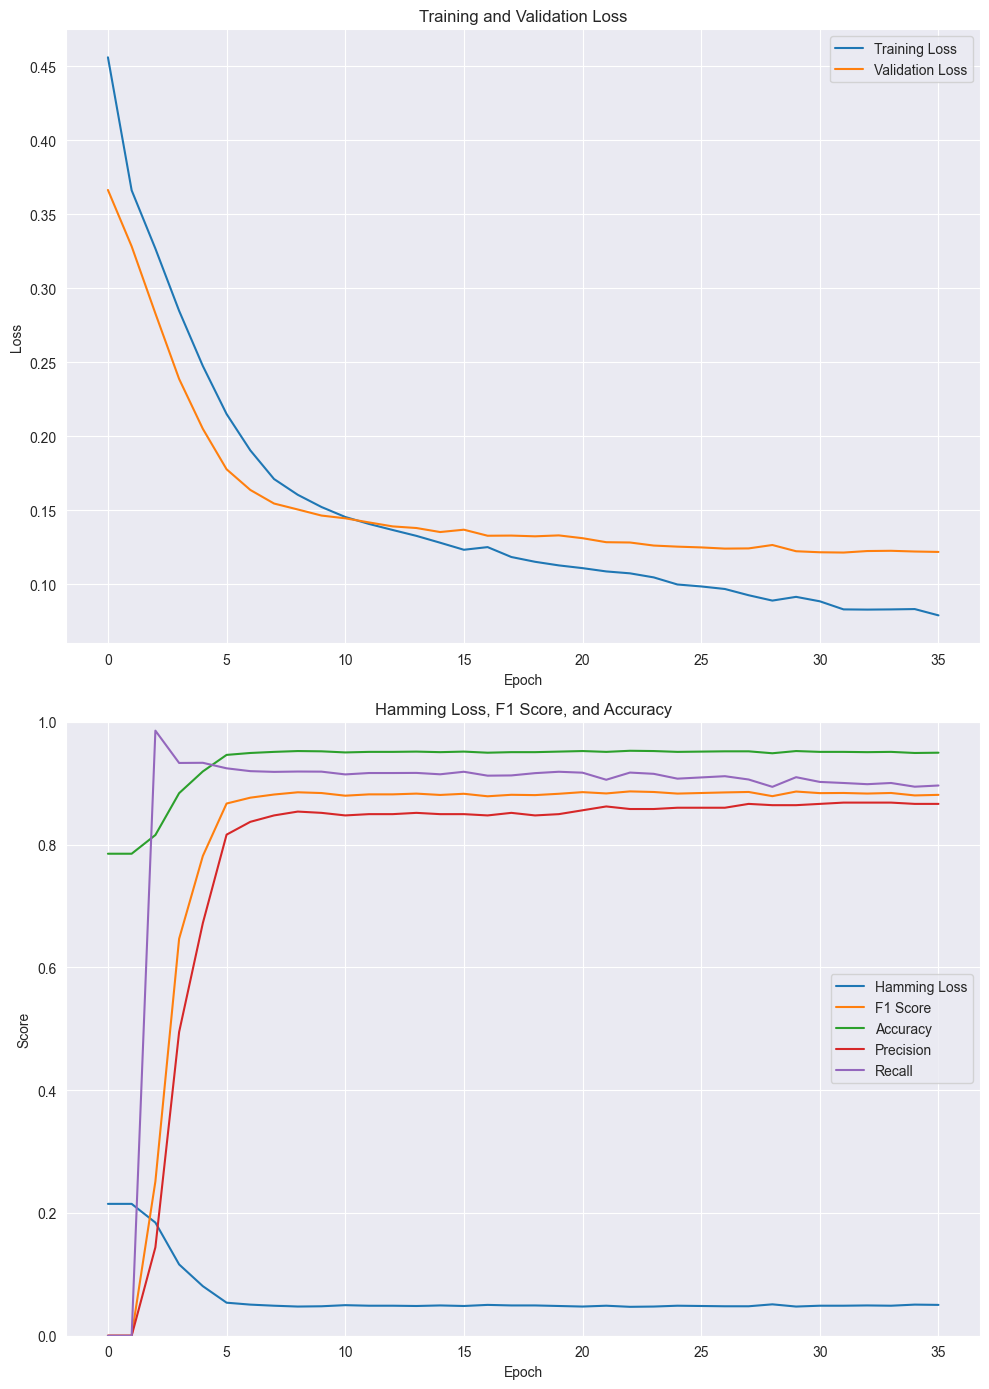

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

ax2.plot(hamming_loss_scores, label='Hamming Loss')
ax2.plot(f1_scores, label='F1 Score')
ax2.plot(accuracy_scores, label='Accuracy')
ax2.plot(precision_scores, label='Precision')
ax2.plot(recall_scores, label='Recall')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1])  # Set y-axis limit (assuming scores are between 0 and 1)
ax2.set_ylabel('Score')
ax2.set_title('Hamming Loss, F1 Score, and Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

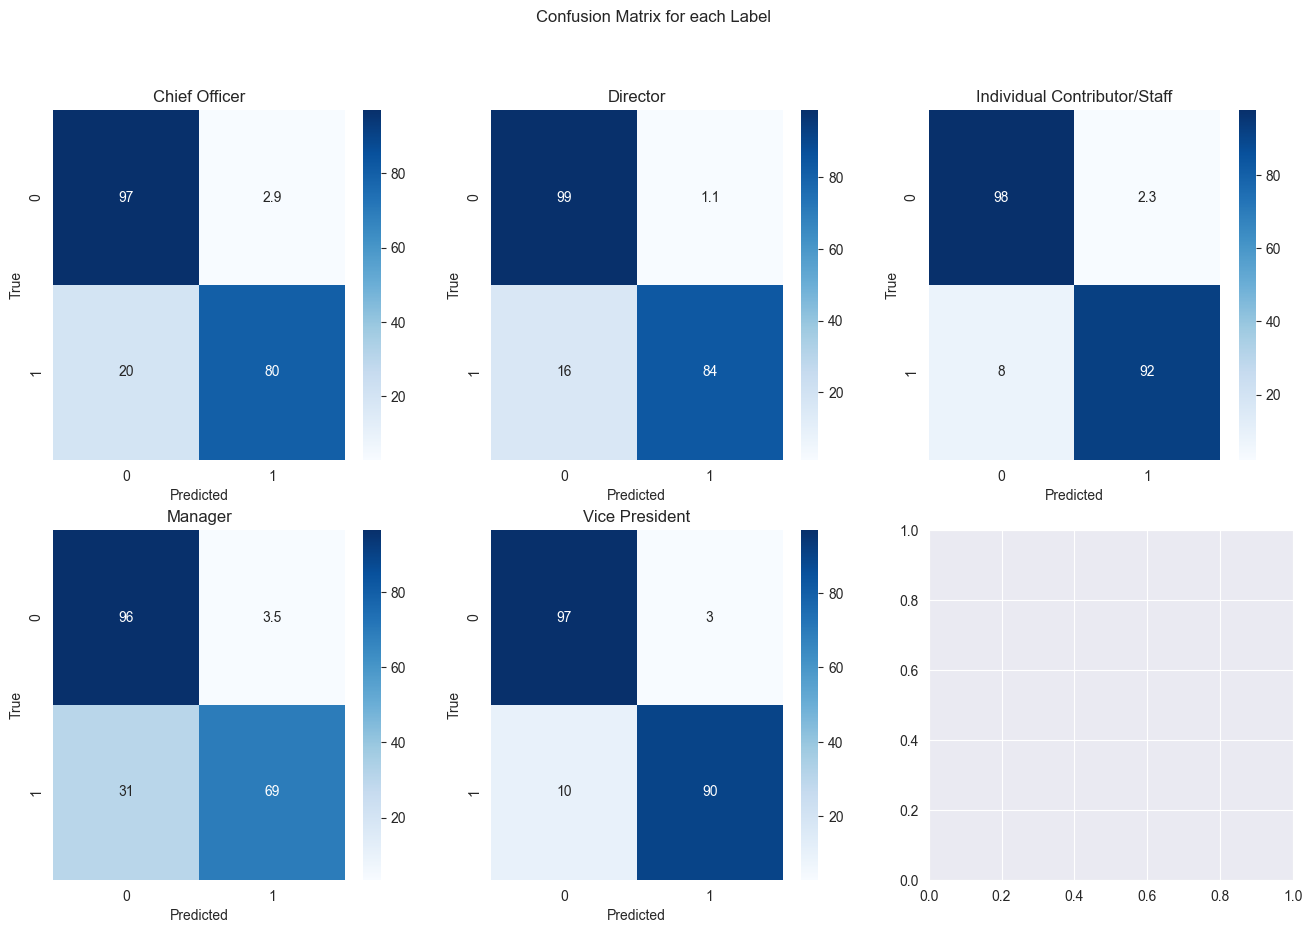

In [36]:
# TODO: https://ieeexplore.ieee.org/document/9711932 multi-label confusion matrix
cm = multilabel_confusion_matrix(best_targets.cpu().numpy(), best_predictions.cpu().numpy())

f, axes = plt.subplots(2, 3, figsize=(16, 10))
f.suptitle("Confusion Matrix for each Label")

for i, matrix in enumerate(cm):
    with np.errstate(invalid='ignore'):
        normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100
        normalized_matrix[np.isnan(normalized_matrix)] = 0 
    ax = axes[i//3, i % 3]
    sns.heatmap(normalized_matrix, annot=True, cmap='Blues', ax = ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(classes_labels[i])
""
plt.show()

In [37]:
report = classification_report(best_targets.cpu(), best_predictions.cpu(), target_names=classes_labels, zero_division=1)
print(report)

                              precision    recall  f1-score   support

               Chief Officer       0.67      0.80      0.73        30
                    Director       0.95      0.84      0.89        98
Individual Contributor/Staff       0.98      0.92      0.95       224
                     Manager       0.71      0.69      0.70        49
              Vice President       0.86      0.90      0.88        78

                   micro avg       0.90      0.87      0.88       479
                   macro avg       0.83      0.83      0.83       479
                weighted avg       0.91      0.87      0.89       479
                 samples avg       0.92      0.90      0.90       479



## Conclusion

The model performs well on the majority of labels; however, it encounters difficulties with the **"Manager"** and **"Chief Officer"** labels, which exhibit a high number of false negatives:
 - As observed from the EDA, the **"Manager"** label is often assigned to regular specialist titles, such as "Systems Engineer; Systems Architect," "Senior Security Architect / Information Security Officer," and so on. This titles do not explicitly indicate that the position should be labeled as a manager in any way, which limits the model's capacity to accurately capture the data. 
- Model may encounter difficulties in predicting **"Chief Officer"** labels due to the fact that in the dataset, titles often contain the words "Chief" or "Chief officer", but are not labelled as "Chief Officer".

Further exploration and improvements steps include:
- Stratifying the data during the train-test split to ensure a balanced distribution of labels in both sets.
- Baseline model implementation for comparison with more complex models. The baseline model could be a simple Logistic Regression classifier with TF-IDF vectorization.
- Trying a hybrid approach where BERT is used for generating embeddings that are then fed into a simpler classifier.